<a href="https://colab.research.google.com/github/andrewkern/disperseNN2/blob/adk_doc/docs/disperseNN2_vignette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set up the environment**

First we need to install disperseNN2 in the colab environment and clone the repo to get example data

In [ ]:
%%bash
# install
pip install disperseNN2
# get example data
git clone https://github.com/chriscrsmith/disperseNN2.git

apt-get install poppler-utils
pip install pdf2image

**Grab preprocessed data**

To speed this example we have created a tarball that already contains simulations for training that have been preprocessed

In [ ]:
%%bash
wget http://sesame.uoregon.edu/~adkern/vignette.tar.gz .
tar zxf vignette.tar.gz

In [3]:
%%bash -t
#mkdir -p vignette
cat disperseNN2/Examples/VCFs/iraptus_meta_full.txt | grep "Scotian Shelf - East" | sed s/"\t"/,/g > vignette/iraptus.csv
count=$(cat disperseNN2/Examples/VCFs/iraptus.vcf | grep -v "##" | grep "#" | wc -w)
for i in $(seq 10 $count); do \
             id=$(cat disperseNN2/Examples/VCFs/iraptus.vcf | grep -v "##" | grep "#" | cut -f $i); \
             grep -w $id vignette/iraptus.csv; \
done | cut -d "," -f 4,5 | sed s/","/"\t"/g > vignette/iraptus.locs

In [4]:
%%bash
disperseNN2 \
             --out vignette/output_dir \
             --seed 12345 \
             --train \
             --max_epochs 100 \
             --validation_split 0.2 \
             --batch_size 10 \
             --learning_rate 1e-4 \
             --pairs 1000 \
             --pairs_encode 100 \
             --gpu any \
             > vignette/output_dir/training_history_12345.txt

2023-07-27 04:52:05.787497: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 04:52:09.029174: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-07-27 04:52:09.030139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-07-27 04:52:09.030200: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

Okay training is done! Let's plot the training history and then display it here in the notebook

In [6]:
!disperseNN2 --plot_history vignette/output_dir/training_history_12345.txt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.


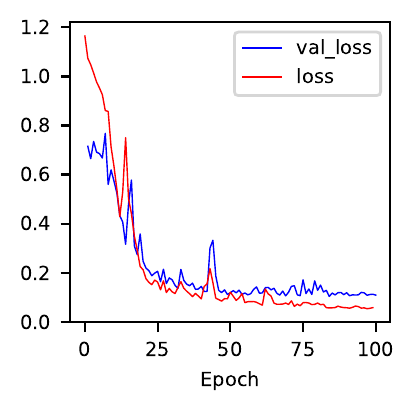

In [13]:


from pdf2image import convert_from_path
from IPython.display import display, Image
images = convert_from_path("vignette/output_dir/training_history_12345.txt_plot.pdf")
for i, image in enumerate(images):
    fname = "image" + str(i) + ".png"
    image.save(fname, "PNG")
Image(fname)